# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel

In [3]:
#PATH = "./data/"

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [4]:
# upload data from local catalogue
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')
insurance_data_test = pd.read_csv(os.path.join(PATH, 'porto', 'test.csv')).set_index('id')

In [5]:
# I've made this notebook in kaggle as the .csv file size was too big for my PC
# So if you had the same problem you could change read_csv path to kaggle and run notebook in kaggle
#insurance_data = pd.read_csv('/kaggle/input/porto-seguro-safe-driver-prediction/train.csv').set_index('id')
#insurance_data_test = pd.read_csv('/kaggle/input/porto-seguro-safe-driver-prediction/test.csv').set_index('id')

In [6]:
pd.set_option('display.max_columns', None)
insurance_data.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [7]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [8]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [11]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

0.9631224658945812

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

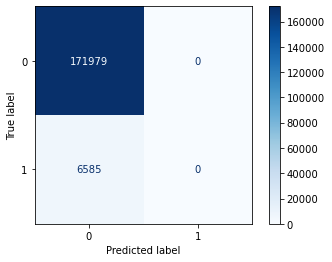

In [12]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [13]:
insurance_data.describe()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.012451,7.299922,0.660823,0.121081,0.153446,0.610991,0.439184,0.551102,8.295933,0.829931,-0.504899,0.725192,-0.157732,6.555340,0.910027,0.832080,1.328890,0.992136,62.215674,2.346072,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.127545,3.546042,0.473430,0.326222,0.360417,0.287643,0.404264,0.793506,2.508270,0.375716,0.788654,2.153463,0.844417,5.501445,0.347106,0.373796,0.978747,0.091619,33.012455,0.832548,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,1.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.400000,0.200000,0.525000,7.000000,1.000000,-1.000000,0.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,32.000000,2.000000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000,0.000000,0.000000,0.700000,0.300000,0.720677,7.000000,1.000000,-1.000000,0.000000,0.000000,7.000000,1.000000,1.000000,2.000000,1.000000,65.000000,3.000000,0.374166,0.765811,0.368

As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

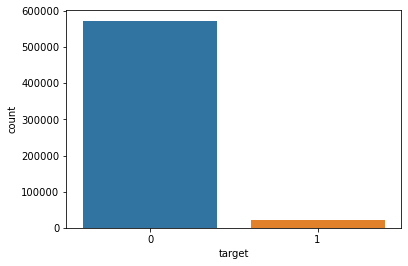

In [14]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [15]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

To prove this I'll take the statement of one of our quiz questions (slightly adjusted):

Let $F$ be a binary classification model applied to a dataset; $x_1, x_2, ..., x_n$ are the instances sorted by the predicted positive class probabilities: $F(x_1) > F(x_2) > ... > F(x_n)$.
$y_1, y_2, ..., y_n$ are true labels (each $y_i$ is either 0 or 1). Consider all pairs $(x_i, x_j)$, where $i > j$. A pair is called defective if $y_i < y_j$.

Let's use the following labels:
* $k$ - number of defective pairs
* $n$ - total number of instances
* $n0$ - number of instances with class 0
* $n1$ - number of instances with class 1

Normalized Gini Coefficient ($Gini_{norm}$) is calculated as Gini coefficient for our model ($Gini_{model}$) devided by Gini coefficient for perfect model without defective pairs ($Gini_{perf}$). Let's look at the example graphs (from left to right) of $ROC (AUC)$, $Gini_{model}$ and $Gini_{perf}$ that I've found on the web.

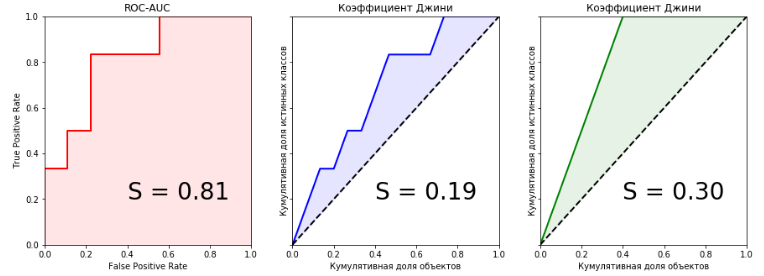

If we look at $Gini_{perf}$ graph, we'll see that it is straight line while $AUC$ and $Gini_{model}$ graphs have fractures. These fractures appear because of defective $(x_i, x_j)$ pairs. If our model was perfect, the $AUC$ graph would be a square and the $Gini_{model}$ graph would be equal to $Gini_{perf}$.

Look at the $AUC$ and $Gini_{model}$ graphs: let's start at the (0,0) point and go up and right. Remember that we've sorted the instances by the predicted positive class probabilities ($F(x_i)$) and compare them to true labels ($y_i$). We start with the instance with maximum predicted value and move one by one: if the predition is true we move up on the graph, and if not we move right.

Thus the maximum area under ROC-curve and Gini curve is reduced by $k$ rectangles and parallelograms correspondingly (in the example below there are 10 defective pairs).

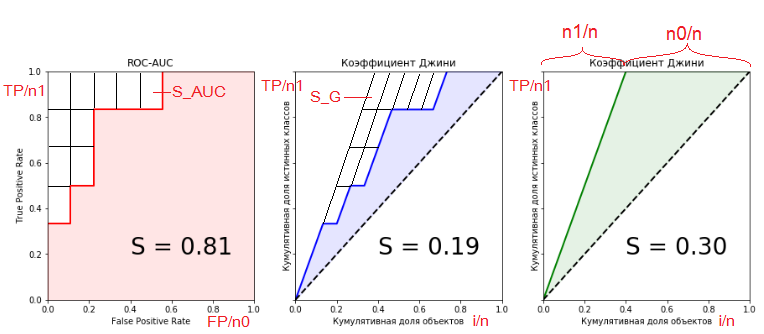

The area of $AUC$ is equal to:

$AUC = 1 - k * S_{AUC},$  $(1)$

where $S_{AUC}$ is area which is subtracted from $AUC$ by each defective pair.

The area of $Gini_{model}$ is equal to:

$Gini_{model} = Gini_{perf} - k * S_G,$  $(2)$

where $S_G$ is area which is subtracted from $Gini_{model}$ by each defective pair.

Take $(2)$ and put into $Gini_{norm}$ expression:

$Gini_{norm} = Gini_{model} / Gini_{perf} = (Gini_{perf} - k * S_G) / Gini_{perf} = 1 - k * S_G / Gini_{perf}.$ $(3)$

The area of $Gini_{perf}$ is equal to:

$Gini_{perf} = 1/2 * 1 * (n0/n) = n0/2n.$ $(4)$

Put $(4)$ to $(3)$:

$Gini_{norm} = 1 - k * S_G / (n0/2n) = 1 - 2 * k * S_G * n / n0.$ $(5)$

The size of one point on vertical axis is equal to $n1$ for all graphs (denominator of TPR). The size of one point on horizontal axis is equal to $n0$ for $AUC$ (denominator of FPR) and $n$ for $Gini$ (denominator of cumulative fracture of all instances). Therefore:

$S_{AUC} = (1/n1) * (1/n0) = 1 / (n1*n0).$ $(6)$

$S_G = (1/n1) * (1/n) = 1 / (n1*n).$ $(7)$

Put $(6)$ to $(1)$:

$AUC = 1 - k * 1 / (n1*n0) = 1 - k / (n1*n0).$

$k = (1 - AUC) * (n1*n0).$ $(8)$

Put $(7)$ to $(5)$:

$Gini_{norm} = 1 - 2 * k * (1 / (n1*n)) * n / n0 = 1 - 2 * k / (n0*n1).$ $(9)$

And finally put $(8)$ to $(9)$:

$Gini_{norm} = 1 - 2 * (1 - AUC) * (n1*n0) / (n0*n1) = 1 - 2 + 2 * AUC = 2 * AUC - 1.$

*quod erat demonstrandum*

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

__Answer:__ according to the task of this competition the main goal is to correctly range the probabilities of filing a claim in order to charge insurance fee correspondingly. So the best metrics here would be _Gini Coefficient_ and _AUC_.

As here we have imbalanced target classes it would be helpful to analyse *Confusion matrix*, use *Precision*, *Recall* and their harmonic mean *F1 score*. We can also use *Kappa* which is classification accuracy normalized by the imbalance of the classes in the data.

Let's calculate the Normalized Gini Coefficient:

In [16]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [17]:
gini_normalized(y_valid, y_pred)

0.2558723581569817

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

## Data preparation

In [18]:
# '-1' values in dataset are actually 'nan' so we need to handle them accordingly
# for binary and categorical features 'nan' would be a separate class

# calculate number and percentage of missing values for numeric features
(insurance_data[numeric_features] == -1).agg(['mean', 'sum'])

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.181065,0.000008,0.000002,0.0,0.071605,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sum,0.0,0.0,0.0,0.0,0.0,0.0,107772.000000,5.000000,1.000000,0.0,42620.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# fill missing values for numeric features with mean values
data = insurance_data
data['ps_reg_03'].replace(-1, data.loc[data['ps_reg_03'] != -1, 'ps_reg_03'].mean(), inplace=True)
data['ps_car_11'].replace(-1, data.loc[data['ps_car_11'] != -1, 'ps_car_11'].mean(), inplace=True)
data['ps_car_12'].replace(-1, data.loc[data['ps_car_12'] != -1, 'ps_car_12'].mean(), inplace=True)
data['ps_car_14'].replace(-1, data.loc[data['ps_car_14'] != -1, 'ps_car_14'].mean(), inplace=True)

In [20]:
# and the same for test dataframe
# calculate number and percentage of missing values for numeric features
(insurance_data_test[numeric_features] == -1).agg(['mean', 'sum'])

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.181094,0.000001,0.0,0.0,0.071465,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sum,0.0,0.0,0.0,0.0,0.0,0.0,161684.000000,1.000000,0.0,0.0,63805.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# fill missing values for numeric features with mean values
data_test = insurance_data_test
data_test['ps_reg_03'].replace(-1, data_test.loc[data_test['ps_reg_03'] != -1, 'ps_reg_03'].mean(), inplace=True)
data_test['ps_car_11'].replace(-1, data_test.loc[data_test['ps_car_11'] != -1, 'ps_car_11'].mean(), inplace=True)
data_test['ps_car_14'].replace(-1, data_test.loc[data_test['ps_car_14'] != -1, 'ps_car_14'].mean(), inplace=True)

In [22]:
y_train = data['target']
X_train = data.drop(columns=['target'])

X_test = data_test

## Perform random under- and over-sampling

In [23]:
df_train =  pd.concat([y_train, X_train], axis=1)

# Class count
count_class_0, count_class_1 = df_train.target.value_counts()

# Divide by class
df_class_0 = df_train[df_train['target'] == 0]
df_class_1 = df_train[df_train['target'] == 1]

In [24]:
df_class_0_under = df_class_0.sample(count_class_1, random_state=42)
df_train_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_train_under.target.value_counts())

Random under-sampling:
0    21694
1    21694
Name: target, dtype: int64


In [25]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True, random_state=42)
df_train_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_train_over.target.value_counts())

Random over-sampling:
0    573518
1    573518
Name: target, dtype: int64


In [26]:
y_train_under = df_train_under['target']
X_train_under = df_train_under.drop(columns=['target'])

y_train_over = df_train_over['target']
X_train_over = df_train_over.drop(columns=['target'])

## Choose the model using cross-validation

In [27]:
pipe_sgd = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=42))])
print('SGD under-sampling ROC-AUC: {:f}'.format(cross_val_score(pipe_sgd, X_train_under, y_train_under, scoring='roc_auc', cv=5).mean()))
print('SGD over-sampling ROC-AUC: {:f}'.format(cross_val_score(pipe_sgd, X_train_over, y_train_over, scoring='roc_auc', cv=5).mean()))

SGD under-sampling ROC-AUC: 0.623715
SGD over-sampling ROC-AUC: 0.633841


In [28]:
pipe_knn = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', KNeighborsClassifier(n_neighbors=1000, n_jobs=-1))])
print('KNN under-sampling ROC-AUC: {:f}'.format(cross_val_score(pipe_knn, X_train_under, y_train_under, scoring='roc_auc', cv=5).mean()))

KNN under-sampling ROC-AUC: 0.615145


In [29]:
pipe_lr = Pipeline(steps=[('preprocessor', preprocessor), 
                          ('classifier', LogisticRegression(random_state=42, max_iter=1000, C=1000, solver='saga', n_jobs=-1))])
print('Logistic regression under-sampling ROC-AUC: {:f}'.format(cross_val_score(pipe_lr, X_train_under, y_train_under, scoring='roc_auc', cv=5).mean()))

Logistic regression under-sampling ROC-AUC: 0.627127


Logistic Regression and KNN for over-sampled data took too long to execute

The best cross-validation AUC score on train dataset was reached using over-sampled SGD (it had the best kaggle score either).

In [30]:
pipe_sgd.fit(X_train_over, y_train_over)
predictions = pipe_sgd.predict_proba(X_test)[:, 1]

output = pd.DataFrame({'id': X_test.index, 'target': predictions})
output.to_csv('porto_sgd_over_1.csv', index=False)

My kaggle private score is 0.26427. My username is 'eugene.sinevich'.

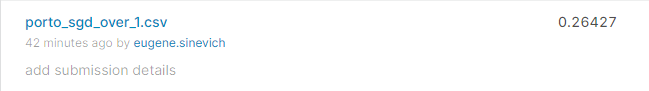